In [ ]:
!pip install torch torchvision
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [3]:
import clip
import torch
import os
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 57.5MiB/s]


In [12]:
# Retrieve images from file
def get_image_paths(image_folder):
    # List all files in the directory
    files = os.listdir(image_folder)
    # Create a list of full file paths
    image_paths = [os.path.join(image_folder, file) for file in files if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif', 'tiff'))]
    return image_paths

# Preprocess images
def preprocess_images(image_paths):
    images = []
    for path in image_paths:
        try:
            image = Image.open(path).convert("RGB")
            image = preprocess(image).unsqueeze(0).to(device)
            images.append(image)
        except (IsADirectoryError, FileNotFoundError, IOError) as e:
            print(f"Skipping {path}: {e}")
    return torch.cat(images) if images else None

In [7]:
# text embeddings
def encode_text(description):
    text = clip.tokenize([description]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text)
    return text_features

# image embeddings
def encode_images(images):
    with torch.no_grad():
        image_features = model.encode_image(images)
    return image_features

# cosine similarity computation
def compute_similarity(text_features, image_features):
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * text_features @ image_features.T).softmax(dim=-1)
    return similarity


In [8]:
# identifying most matching images
def find_top(similarity, image_paths, top_k=5):
    values, indices = similarity[0].topk(top_k)
    return [image_paths[idx] for idx in indices]

# cumulative function
def search(description, image_folder, top_k=5):
    image_paths = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder)]
    images = preprocess_images(image_paths)
    text_features = encode_text(description)
    image_features = encode_images(images)
    similarity = compute_similarity(text_features, image_features)
    top_images = find_top(similarity, image_paths, top_k=top_k)
    return top_images

In [19]:
# display most matching images
def display_images(image_paths):
    images = [Image.open(path) for path in image_paths]
    if len(images) == 1:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.imshow(images[0])
        ax.set_title(os.path.basename(image_paths[0]))
        ax.axis('off')
    else:
        fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
        for ax, img, path in zip(axs, images, image_paths):
            ax.imshow(img)
            ax.set_title(os.path.basename(path))
            ax.axis('off')
    plt.show()

In [25]:
# testing code
dir = '/content/sample_data'
description = 'a peacock with bright colors'
num_top = 1

top_images = search(description, dir, num_top)


Skipping /content/sample_data/.ipynb_checkpoints: [Errno 21] Is a directory: '/content/sample_data/.ipynb_checkpoints'


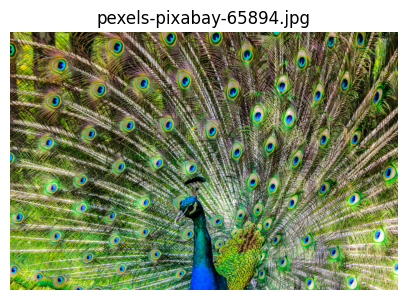

In [26]:
display_images(top_images)